# Load Spotify Dataset

In [1]:
# Load the dataset
import pandas as pd
df = pd.read_csv(r"J:\CodeAlpha_MUSIC_RECOMMDATION_SYSTEM\data.csv")  # Replace with the actual dataset path
df = df.sample(n=5000,random_state=42).reset_index(drop=True)
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.910,1977,0.500,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805
1,0.583,1976,0.930,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104
2,0.647,1994,0.157,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744
3,0.196,1957,0.937,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764
4,0.422,1921,0.995,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978


# Features and Scaling

In [2]:
# Select relevant numerical features for clustering
from sklearn.preprocessing import StandardScaler

numerical_features = [
    "valence", "danceability", "energy", "tempo", 
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

# Standardize the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

# Train Test Split

In [3]:
# Optional: Split for testing or validation
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Elbow Method Plot
To find optimal K

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

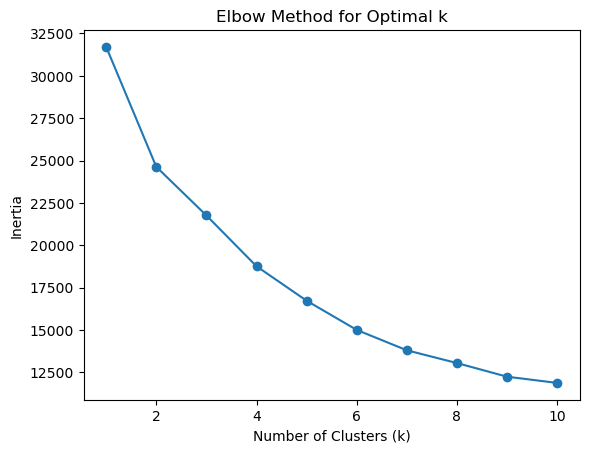

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


# Applying Kmeans

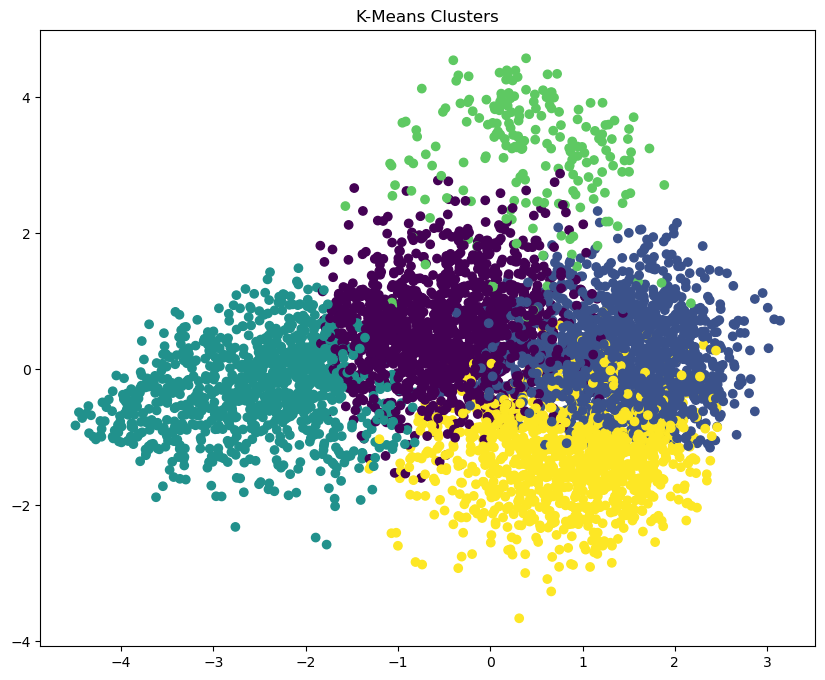

In [5]:
# Apply K-Means clustering with optimal k (e.g., k=5)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(10,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

# Recommendation System With Kmeans

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df["name"] == song_name]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    # Get top recommendations
    similar_songs = np.argsort(similarity[song_index])[-(num_recommendations + 1):-1][::-1]
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations

In [7]:
# Example usage
input_song =  "Camby Bolongo"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Camby Bolongo':


,name,year,artists
3444,Bitch to the Boys,1982,['Shakatak']
3027,Chella llà - Instrument and base Version,1942,['Orchestra Studio 7']
4899,Danse Fambeaux,1968,['Dr. John']
3124,"Aragon - From The ""Coffy"" Soundtrack",1973,['Roy Ayers']
647,Into Black,2011,['Blouse']


In [8]:
# Example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'Soul Junction':


,name,year,artists
1088,Legends of the Fall,1995,"['James Horner', 'Vic Frasier']"
3489,"Water Music Suite No. 1 In F, HWV 348: 2. Adag...",1983,"['George Frideric Handel', 'The English Concer..."
2473,"Le sacre du printemps: Part 1 ""Adoration of th...",1948,"['Igor Stravinsky', 'Columbia Symphony Orchest..."
1277,Saving Buckbeak,2004,['John Williams']
3385,"Tristan und Isolde, WWV 90: Prelude",1953,"['Richard Wagner', 'Arturo Toscanini']"


In [9]:
# save df
df.to_csv("clustered_df.csv")

In [10]:
df

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
0,0.910,1977,0.5000,['Idris Muhammad'],0.894,273067,0.5210,0,0KdzyvsBqX1HV3uLxGm2JV,0.772000,4,0.068,-7.048,1,Camby Bolongo,34,1977,0.0847,126.805,1
1,0.583,1976,0.9300,['Stan Getz'],0.585,182200,0.2720,0,1f4eO5waC6glPLXUhYKLm2,0.115000,11,0.128,-16.693,0,Just One of Those Things,26,1976,0.0802,90.104,0
2,0.647,1994,0.1570,"['Warren G', 'The Twinz']",0.878,179933,0.5200,1,1X07ZfF5KQt8dyJ5kAkVAQ,0.000000,7,0.173,-12.609,1,Recognize,38,1994-06-07,0.4030,90.744,1
3,0.196,1957,0.9370,['Red Garland Quintet'],0.463,925947,0.2870,0,5wmMDeM4qvLfwqLa2cvoks,0.837000,0,0.112,-11.758,0,Soul Junction,13,1957,0.0363,186.764,2
4,0.422,1921,0.9950,['Ignacio Corsini'],0.648,154240,0.0995,0,0SK1upzAP6NvIgF0uGh6z2,0.846000,11,0.112,-22.429,1,Flor Marchita - Remasterizado,0,1921-03-20,0.1050,71.978,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.612,2001,0.1840,['Alice Cooper'],0.533,186093,0.7030,0,5LY8GsHfU7G6tmeXxStEb6,0.000000,2,0.101,-6.364,1,No More Mr. Nice Guy - 2002 Remaster,42,2001,0.0423,128.761,1
4996,0.919,1999,0.0819,['Britney Spears'],0.714,200467,0.8520,0,6039GmVngyHmWfOuWOhjCK,0.000000,8,0.285,-6.570,1,Soda Pop,40,1999-01-12,0.0565,92.016,1
4997,0.345,2012,0.8820,['Issa Ibrahim'],0.215,167741,0.3190,0,4UuMkQLjxSgcrW2d1zFIJT,0.000013,0,0.228,-12.845,1,Susan,0,2012-09-03,0.0363,55.846,2
4998,0.286,1942,0.9900,"['Felix Mendelssohn', 'Paul Robeson Jr.', 'Law...",0.393,187267,0.0747,0,2rRxJzTQyvm5Wwj9ObnZvv,0.078400,10,0.102,-17.930,1,"The Lord God of Abraham, from Elijah, Op. 70",0,1942,0.0321,101.457,2
